## Imports and Preliminaries

In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cpu


## Dataset Class

In [ ]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        elif split == "test":
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]
        else:
            # ground truth images
            img_dirs = [(base_dir / "ground_truth", 0, "ground_truth")]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

## Create Datasets

In [49]:
from torch.utils.data import ConcatDataset
import os

MVTEC_ROOT = "./Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")
ground_truth_dataset = build_concat("ground_truth")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


TRAINING IMAGES


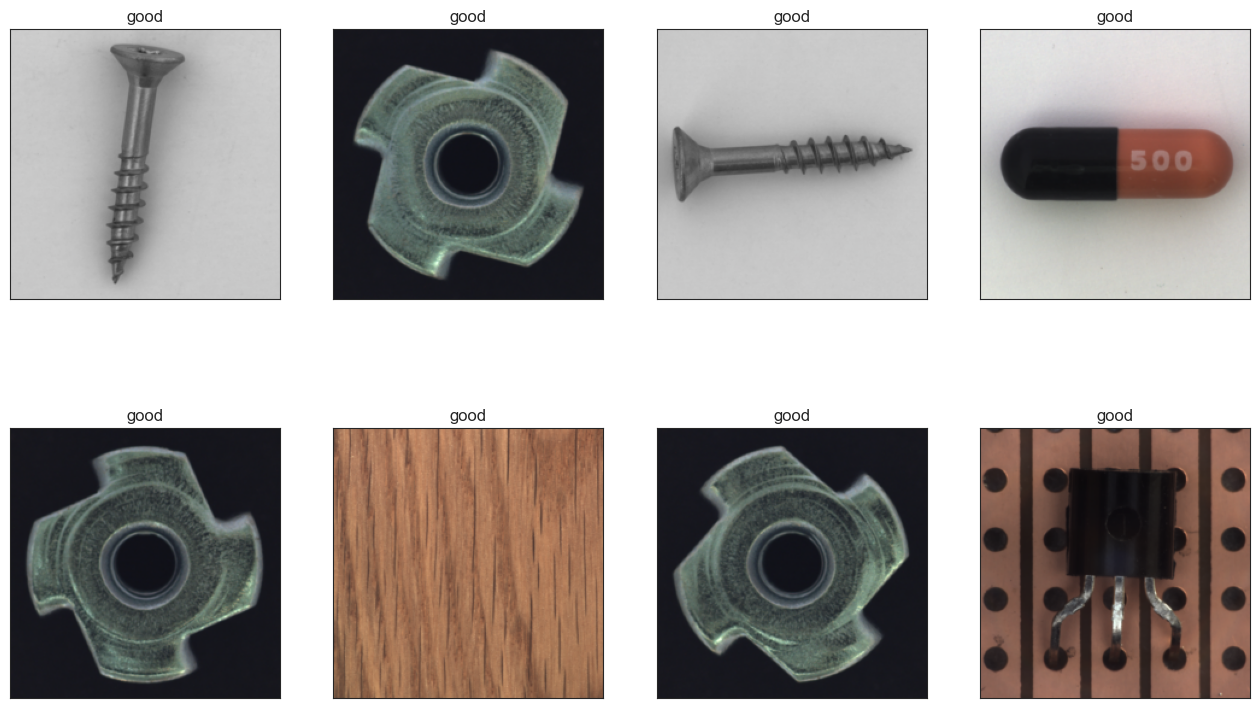

TESTING IMAGES


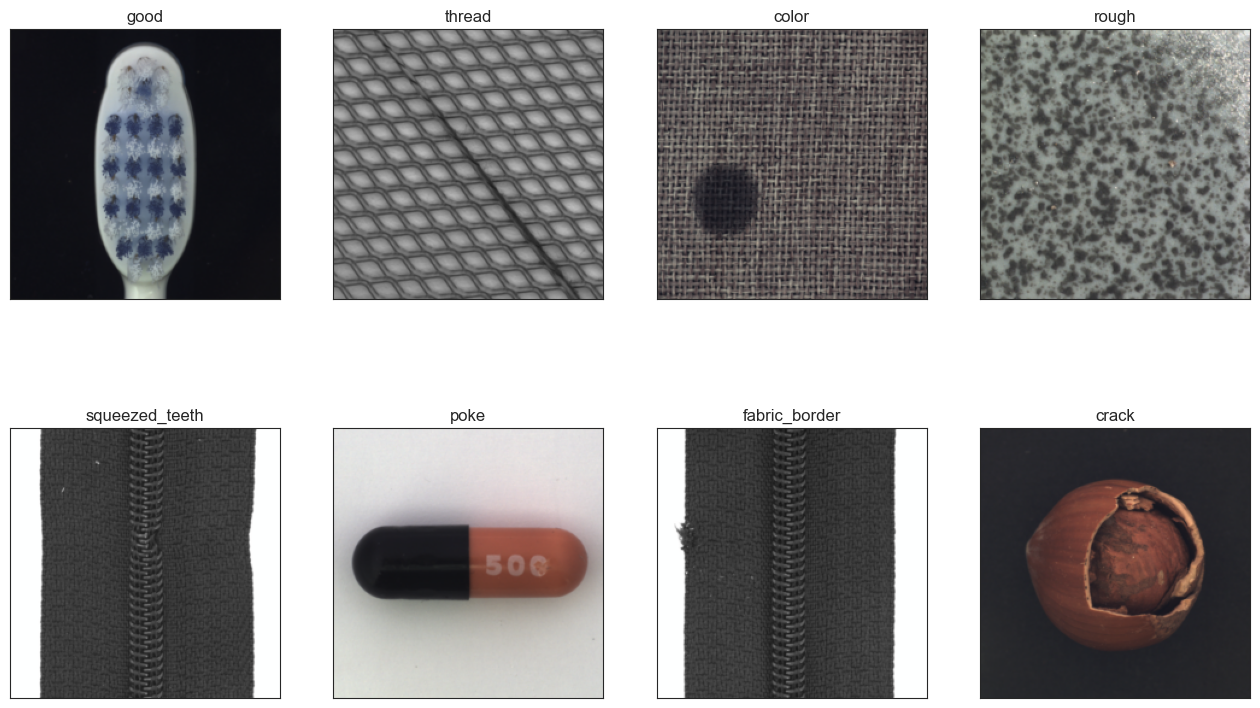

In [50]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

ground_truth_example_loader = DataLoader(
    dataset=ground_truth_dataset, batch_size=8, shuffle=True
)
print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)
print("GROUND TRUTH MASKS")
show_dataset_examples(ground_truth_example_loader)

## Embed training features, compare to Test data and draw conclusion

In [51]:
EMBEDDING_FILE_EXT = "embeddings.npz"

def save_embeddings_compressed(embeddings, save_path="./embeddings", dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Separate embeddings and labels
    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    # Save as compressed numpy
    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"Compressed embeddings saved to: {npz_path}")
    print(f"File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path, n_register_tokens=4):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]  # shape: (N_images, N_tokens, D)
    labels = data["labels"]

    # Remove register tokens from each image
    if n_register_tokens > 0:
        emb_arrays = emb_arrays[:, n_register_tokens:, :]

    # Convert to list of tuples
    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(
        f"Loaded {len(embeddings)} embeddings with shape {emb_arrays.shape[1:]} per image"
    )

    return embeddings

In [52]:
def embed_and_save_features(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m", device="cuda"
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            if isinstance(feats, dict):
                x = feats.get("x_norm")  
            else:
                x = feats

            emb = x.mean(dim=1)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split, save_path='./NEW_embeddings')
    return embeddings

In [53]:
import csv 
def cosine_sim_matrix(test_vec, gt_mat):
    """
    test_vec: (384,)
    gt_mat:   (N, 384)
    returns:  (N,)
    """
    return (gt_mat @ test_vec).ravel() 


def compare_and_draw_conclusion(
    threshold=0.8, rank=10, csv_path="results.csv", embedding_folder="./embeddings"
):
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

    embeddings_GT = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train")
    )

    embeddings_Test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test")
    )

    gt_vecs, _ = zip(*embeddings_GT)
    gt_mat = np.asarray(gt_vecs, dtype=np.float32)

    # Normalize GT matrix once
    gt_mat /= np.linalg.norm(gt_mat, axis=1, keepdims=True) + 1e-8

    results = []
    correct = 0
    total = 0

    for idx, (test_vec, label) in enumerate(embeddings_Test):

        tv = np.asarray(test_vec, dtype=np.float32)
        tv /= np.linalg.norm(tv) + 1e-8

        sims = cosine_sim_matrix(tv, gt_mat)  # vectorized

        # select rank-th highest similarity
        kth = np.partition(sims, -rank)[-rank] if len(sims) >= rank else sims.max()

        pred = "good" if kth > threshold else "anomalous"
        true = "good" if str(label).lower() == "good" else "anomalous"

        ok = int(pred == true)
        correct += ok
        total += 1

        results.append(
            {
                "Test_Index": total,
                "True_Label": true,
                "Predicted_Label": pred,
                f"{rank}th_Best_Similarity": kth,
                "Correct": ok,
            }
        )

    acc = correct / total if total else 0

    results.append(
        {
            "Test_Index": "TOTAL",
            "True_Label": "",
            "Predicted_Label": "",
            f"{rank}th_Best_Similarity": "",
            "Correct": f"{acc*100:.2f}% ({correct}/{total})",
        }
    )

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Saved: {csv_path}")
    return acc

In [93]:
# on GPU it takes roughly 3 minutes 18s to process all training and testing embeddings

# compare_and_draw_conclusion(threshold=0.97, rank=25)

In [55]:
import numpy as np


def load_embeddings_only(path, max_samples=None):
    data = np.load(path, allow_pickle=True)

    if "embeddings" in data:
        X = data["embeddings"]
        y = data.get("labels", None)
    else:
        pairs = data["arr_0"]
        X = np.stack([e for e, _ in pairs])
        y = np.array([l for _, l in pairs])

    if max_samples is not None:
        X = X[:max_samples]
        if y is not None:
            y = y[:max_samples]

    return X, y

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def visualize_pca(embeddings, labels=None, title="PCA visualization"):

    embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

    pca = PCA(n_components=2)
    Xp = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))

    if labels is None:
        plt.scatter(Xp[:, 0], Xp[:, 1], s=8, alpha=0.7)
    else:
        labels = labels.astype(str)
        for lbl in np.unique(labels):
            idx = labels == lbl
            plt.scatter(
                Xp[idx, 0],
                Xp[idx, 1],
                s=10,
                alpha=0.7,
                label=lbl,
            )
        plt.legend()

    var = pca.explained_variance_ratio_ * 100
    plt.xlabel(f"PC1 ({var[0]:.1f}%)")
    plt.ylabel(f"PC2 ({var[1]:.1f}%)")
    plt.title(title)
    plt.grid(True)
    plt.show()

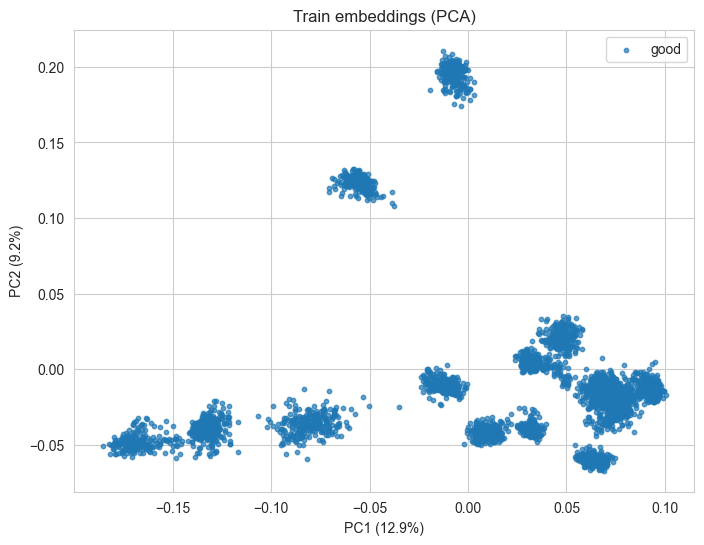

In [57]:
train_path = f"./embeddings/train_{EMBEDDING_FILE_EXT}"
test_path = f"./embeddings/test_{EMBEDDING_FILE_EXT}"

X_test, y_test = load_embeddings_only(
    train_path,
)
visualize_pca(X_test, y_test, "Train embeddings (PCA)")

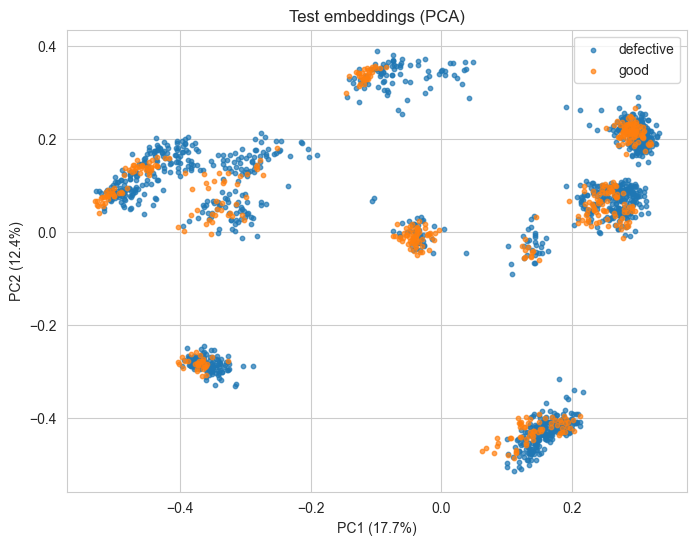

In [ ]:
X_test, y_test = load_embeddings_only(
    test_path,
)

y_bin = ["good" if str(label).lower() == "good" else "defective" for label in y_test ]

y_bin = np.array(y_bin)

visualize_pca(X_test, y_bin, "Test embeddings (PCA)")

In [58]:
def extract_patch_embeddings(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m"
):
    """
    Extract patch embeddings for all images in a dataloader.
    Returns: patches_embeddings [N_images, N_patches, D], labels [N_images]
    """
    model = timm.create_model(model_url, pretrained=True)
    model.eval().to(device)

    grid_size = model.patch_embed.grid_size
    print(grid_size)

    all_patches = []
    all_labels = []
    i = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Get patch features (no CLS token)
            feats = model.forward_features(images)
            if isinstance(feats, dict):
                patch_feats = feats.get("x_norm")  # shape: [B, N_patches, D]
            else:
                patch_feats = feats[:, 1:, :]  # drop CLS token if exists

            patch_feats = patch_feats.cpu().numpy()
            print("patch shape:", patch_feats.shape)
            all_patches.append(patch_feats)
            all_labels.extend(labels)

            print('loaded batch', i)
            i += 1
            # if i > 5: break

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.array(all_labels)

    embeddings = [(patch, label) for patch, label in zip(all_patches, all_labels)]

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split, save_path='./NEW_embeddings')
    return all_patches, all_labels

In [98]:
# extract_patch_embeddings(train_loader, "train")

In [87]:
import faiss



train_data = load_embeddings_compressed(f"./NEW_embeddings/train_{EMBEDDING_FILE_EXT}")
train_patches, train_labels = zip(*train_data)

test_data = load_embeddings_compressed(f"./NEW_embeddings/test_{EMBEDDING_FILE_EXT}")
test_patches, test_labels = zip(*test_data)

# unzip
train_patches_list, train_labels = zip(*train_data)
test_patches_list, test_labels = zip(*test_data)

# convert to float32 NumPy arrays
train_patches = np.stack([np.array(p, dtype=np.float32) for p in train_patches_list])
test_patches = np.stack([np.array(p, dtype=np.float32) for p in test_patches_list])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Flatten train/test patches to 2D arrays
num_train_images, num_patches_per_image, dim = train_patches.shape
num_test_images = test_patches.shape[0]

train_patches_flat = train_patches.reshape(-1, dim)  # (3629*200, 384)
test_patches_flat = test_patches.reshape(-1, dim)  # (1725*200, 384)
# now train_patches and test_patches are proper 2D arrays
print(train_patches_flat.shape, test_patches_flat.shape)


# L2-normalize
faiss.normalize_L2(train_patches_flat)
faiss.normalize_L2(test_patches_flat)

Loading compressed embeddings from: ./NEW_embeddings/train_embeddings.npz
Loaded 3629 embeddings with shape (196, 384) per image
Loading compressed embeddings from: ./NEW_embeddings/test_embeddings.npz
Loaded 1725 embeddings with shape (196, 384) per image
(711284, 384) (338100, 384)


In [107]:
from sklearn.decomposition import PCA

pca_dim = 128
pca = PCA(n_components=pca_dim, whiten=True, svd_solver="randomized")
memory_bank_reduced = pca.fit_transform(train_patches_flat)
test_patches_reduced = pca.transform(test_patches_flat)


KeyboardInterrupt: 

In [110]:
print(memory_bank_reduced.shape)

(711284, 128)


In [111]:
# Ensure memory_bank_reduced and test_patches_reduced are contiguous
memory_bank_reduced = np.ascontiguousarray(memory_bank_reduced, dtype=np.float32)
test_patches_reduced = np.ascontiguousarray(test_patches_reduced, dtype=np.float32)

# Now normalize
faiss.normalize_L2(memory_bank_reduced)
faiss.normalize_L2(test_patches_reduced)

In [125]:
dim = memory_bank_reduced.shape[1]
print(dim)
index = faiss.IndexFlatL2(dim)  # exact L2 search
index.add(memory_bank_reduced)

print(memory_bank_reduced.shape)

128
(711284, 128)


In [126]:
k = 5  # nearest neighbor
# distances, indices = index.search(test_patches_reduced, k)

train_distances, train_indices = index.search(memory_bank_reduced, k)
# Remove self-match
train_distances = train_distances[:, 1:]
train_indices = train_indices[:, 1:]


In [127]:
print(train_distances.shape)

(711284, 4)


In [128]:
# np.savez_compressed(
#     "./NEW_embeddings/test_patch_knn.npz", distances=distances, indices=indices
# )

np.savez_compressed(
    "./NEW_embeddings/train_patch_knn.npz",
    train_distances=train_distances,
    train_indices=train_indices,
)

In [130]:
knn_data = np.load("./NEW_embeddings/test_patch_knn.npz", allow_pickle=True)
knn_training = np.load("./NEW_embeddings/train_patch_knn.npz", allow_pickle=True)


distances = knn_data["distances"]
indices = knn_data.get("indices", None)

train_distances = knn_training["train_distances"]

print(distances)
print(train_distances)
# print(np.allclose(distances, train_distances))
# print("Test query shape:", test_patches_reduced.shape)
# print("Train query shape:", memory_bank_reduced.shape)

[[0.21222472 0.2211206  0.22929776 0.2302059  0.2308675 ]
 [0.21297073 0.21311891 0.21354377 0.22196102 0.22658527]
 [0.21428216 0.21480143 0.21532488 0.21574628 0.22354662]
 ...
 [0.47262585 0.51646304 0.5323266  0.55498326 0.5605047 ]
 [0.44399452 0.4477471  0.4483565  0.44972348 0.45899737]
 [0.25779402 0.26761103 0.28881776 0.3010174  0.30925858]]
[[0.05900919 0.0626452  0.0674324  0.06928122]
 [0.06049228 0.06944275 0.06966877 0.08077717]
 [0.06049228 0.08047545 0.08415926 0.08841836]
 ...
 [0.05990171 0.09500384 0.22349596 0.23528719]
 [0.20106936 0.23113286 0.23599029 0.2414676 ]
 [0.07582641 0.09644759 0.09651768 0.10511005]]


In [132]:
patch_scores = distances.mean(axis=1)
train_patch_scores = train_distances.mean(axis=1)
print(patch_scores.shape)
print(train_patch_scores.shape)

(338100,)
(711284,)


In [133]:
num_patches_per_image = 196
num_test_images = 1725
h = w = 14
# anomaly_maps = distances.reshape(num_test_images, num_patches_per_image)
anomaly_map = patch_scores.reshape(num_test_images, h, w)
train_map = train_patch_scores.reshape(num_train_images, h, w)

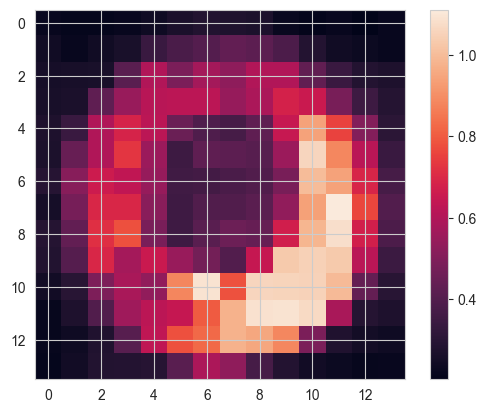

In [136]:
plt.imshow(anomaly_map[0])
plt.colorbar()



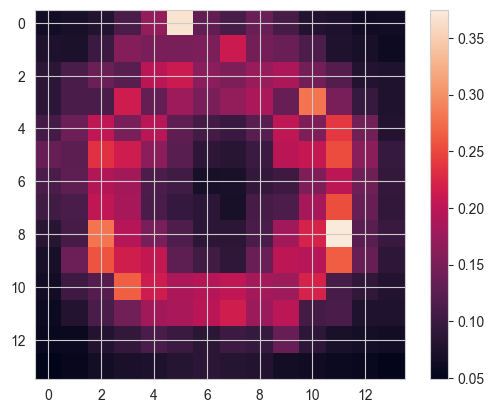

In [137]:
plt.imshow(train_map[0])
plt.colorbar()

In [ ]:
# from scipy.ndimage import gaussian_filter

# anomaly_maps_smooth = gaussian_filter(anomaly_maps, sigma=1)

In [162]:
# test_image_scores_max = anomaly_map.max(axis=1)  # max over all patches per image
# test_image_scores_mean = anomaly_map.mean(axis=1)  # mean over all patches per image
test_image_scores_max = anomaly_map.max(axis=(1, 2))  # max over all patches per image
test_image_scores_mean = anomaly_map.mean(
    axis=(1, 2)
)  # mean over all patches per image
print(test_image_scores_max)

[1.1107     1.0043377  1.1485412  ... 0.588246   0.78442645 0.81220436]


In [163]:
train_image_scores_max = train_map.max(axis=(1, 2))
train_image_scores_mean = train_map.mean(axis=(1, 2))
print(train_image_scores_max)

[0.37501436 0.3472484  0.32344708 ... 0.40938848 0.28914025 0.25229892]


In [170]:
threshold = np.percentile(train_image_scores_max, 85)  # choose top 5% as anomalous
pred_labels = (test_image_scores_max > threshold).astype(int)

print(pred_labels[:50])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


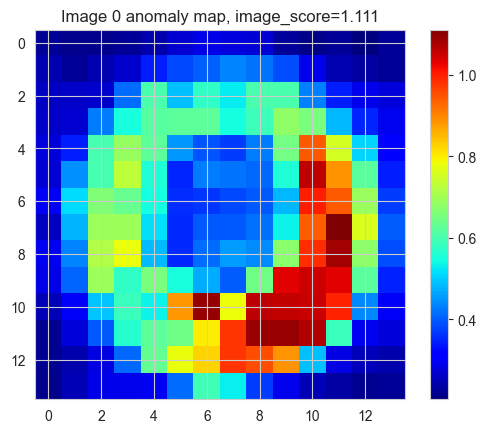

In [144]:
import matplotlib.pyplot as plt

plt.imshow(anomaly_map[0], cmap="jet")
plt.title(f"Image 0 anomaly map, image_score={image_scores_max[0]:.3f}")
plt.colorbar()
plt.show()

In [171]:
true_labels = np.array(
    [0 if label == "good" else 1 for label in test_labels], dtype=int
)
print(true_labels)
accuracy = (pred_labels == true_labels).mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

[1 1 1 ... 1 1 1]
Accuracy: 75.88%


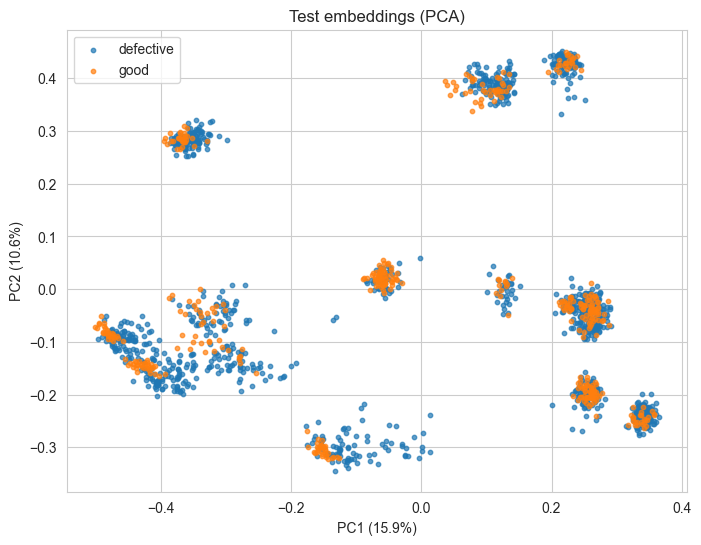

In [172]:
X_test, y_test = load_embeddings_only(
    "./NEW_embeddings/test_embeddings.npz",
)

# X_test.shape -> (num_images, num_patches, patch_dim)
num_images = X_test.shape[0]
X_test_flat = X_test.reshape(num_images, -1)  # (num_images, num_patches*patch_dim)


y_bin = ["good" if str(label).lower() == "good" else "defective" for label in y_test]

y_bin = np.array(y_bin)

visualize_pca(X_test_flat, y_bin, "Test embeddings (PCA)")